In [1]:
import time
import torch
from torch import distributions as D
from matplotlib import pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm

In [2]:
# Hack to import from a parent directory
import os, sys
path = '..'
if path not in sys.path:
    sys.path.append(path)

from LogitNormal import *
from TruncatedNormal import *
from mean_field import *
from obs_and_flow_minibatch_rev import *

## Generate data

Given fixed hyperparameters $\mu_\theta, \sigma_\theta, a, b, \mu_{x_0}, \sigma_x, \sigma_y$ and observed $y$, consider the following toy model:
- $\theta_0, \theta_1 \sim \text{LogitNormal}(\mu_\theta, \sigma_\theta, a, b)$
- $x_0 \sim N(\mu_{x_0}, \sigma_x)$
- $x_t \sim N(\theta_0+\theta_1x_{t-1}, \sigma_x)$
- $y_t \sim N(x_t, \sigma_y)$

We make simplifying assumptions that each state $x_t$ is one dimensional and every time step $y_t$ is observed. Our data consist of $N$ independent sequences of $y$.

In [3]:
def generate_data(N, T, dt, mu_theta, sigma_theta, a_theta, b_theta,
                  mu_x, sigma_x, sigma_y, obs_every=None, theta=None):
    torch.manual_seed(0)
    if obs_every is None:
        obs_every = dt
    #assert obs_every % dt == 0, 'obs_every must be divisible by dt'
    obs_every_step = int(obs_every / dt)
    
    # Sample theta
    p_theta = RescaledLogitNormal(mu_theta, sigma_theta, a=a_theta, b=b_theta)
    if theta is None:
        theta = p_theta.sample() # (2, )
    
    # Allocate x tensor
    M = int(T / dt) + 1
    x = torch.empty((N, M)) # N - number of independent sequences; M - length of each sequence
    
    # Sample x0
    p_x0 = D.normal.Normal(mu_x, sigma_x)
    x[:, 0] = p_x0.sample((N, )) # (N, )
    
    # Sample x_t, t > 0
    for i in range(1, M):
        p_xt = D.normal.Normal(theta[0] + theta[1] * x[:, i - 1], sigma_x)
        
        # Draw sample
        x[:, i] = p_xt.sample() # (N, )
    
    # Sample y
    x_for_y = x[:, ::obs_every_step]
    p_y = D.normal.Normal(x_for_y, sigma_y)
    y = p_y.sample() # (N, M_obs)
    
    # Observation timestamp t_y
    t_x = torch.arange(0, T + dt, dt)
    t_y = torch.arange(0, T + dt, obs_every)
    assert(len(t_y) == y.shape[1] and t_y[-1] == T)
    y_dict = {'t_y': t_y, 'y': y, 'sigma_y': sigma_y}
    
    return p_theta, theta, p_x0, x, y_dict

In [4]:
# theta hyperparameters
mu_theta = torch.tensor([0., 0.5])
sigma_theta = torch.tensor([1., 1.])
a_theta = torch.tensor([-2., -1.])
b_theta = torch.tensor([2., 1.])
theta = torch.tensor([0.6, 0.9])

# x hyperparameters
mu_x = torch.tensor(0.)
sigma_x = torch.tensor(0.8)

# y hyperparameter
sigma_y = torch.tensor(1.)

In [5]:
N, T, dt, obs_every = 1, 1000, 1.0, 10
p_theta, theta, p_x0, x, y_dict = generate_data(N, T, dt, mu_theta, sigma_theta, a_theta, b_theta,
                                                mu_x, sigma_x, sigma_y, obs_every=obs_every, theta=theta)

In [6]:
save_dir = 'data/toy_ssm1'

In [ ]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
theta_file = '{}/theta.pt'.format(save_dir)
p_x0_file = '{}/p_x0.pt'.format(save_dir)
y_dict_file = '{}/y_dict.pt'.format(save_dir)
torch.save(theta, theta_file)
torch.save(p_x0, p_x0_file)
torch.save(y_dict, y_dict_file)

## Plot data

In [7]:
def plot_theta(p_theta, theta, num_pts=1000, eps=1e-6):
    fig, axes = plt.subplots(1, 3, figsize=(4*3, 4))
    
    a, b = p_theta.a, p_theta.b
    theta_range = torch.from_numpy(np.linspace(a + eps, b - eps, num_pts)).float()
    
    pdf_prior = torch.exp(p_theta.log_prob(theta_range)).detach()
    approx_int_prior = pdf_prior.sum(0) * (b - a) / num_pts
    assert torch.allclose(approx_int_prior, torch.tensor(1.0), rtol=1e-3)
    
    labels = ['$\\theta_0$', '$\\theta_1$']
    for i, ax in enumerate(axes):
        if i < 2:
            ax.plot(theta_range[:, i], pdf_prior[:, i], linewidth=2, label='prior')
            ax.axvline(theta[i], color='gray', label='true $\\theta$')
            ax.set_xlabel(labels[i])
            if i == 0: ax.set_ylabel('density')
        else:
            handles, labels = axes[0].get_legend_handles_labels()
            ax.legend(handles, labels, loc='center left')
            ax.axis('off')
    plt.tight_layout()

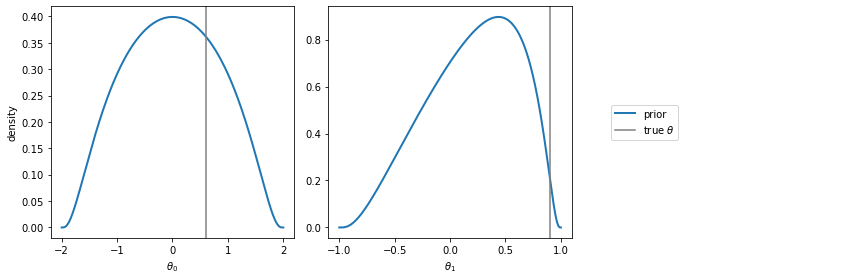

In [8]:
plot_theta(p_theta, theta)

In [9]:
def plot_path(x, y, t_x, t_y, title=None, state_dim=1):
    N, time_steps = x.shape
    fig, axes = plt.subplots(state_dim, figsize=(15, 4*state_dim), sharex=True)
    axes = np.atleast_1d(axes)
    
    for i, ax in enumerate(axes):            
        ax.plot(t_x, x[i, :], label='latent state')
        ax.plot(t_y, y[i, :], label='observation', linestyle='', marker='o')        
        ax.legend()
        if i == 0 and title:
            ax.set_title(title)
    ax.set_xlabel('hour')
    plt.tight_layout()

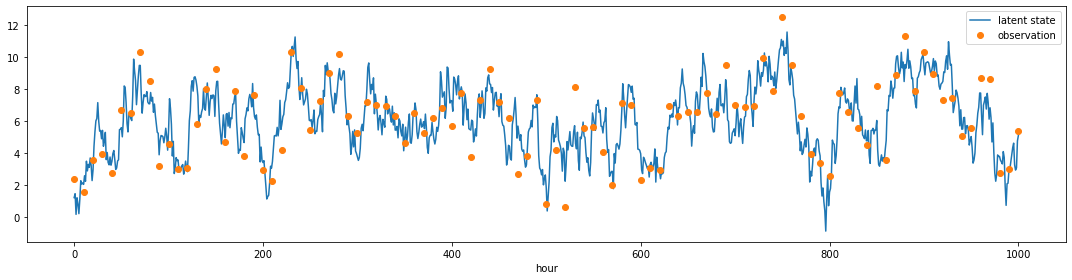

In [10]:
y, t_y = y_dict['y'], y_dict['t_y']
t_x = torch.arange(0, T + dt, dt)
plot_path(x, y, t_x, t_y)

## Inference

Objective (ELBO) for minibatch $M_k$:
$$
\begin{align}
\mathcal{L}_k &= \frac{1}{S} \sum_s \left[ \log p(\theta, x, y) - \log q(\theta, x|y) \right] \\
  &= \frac{1}{S} \sum_s \left[\log p(\theta^{(s)}) - \log q(\theta^{(s)}) + \frac{T}{|M_k|} \sum_{i \in M_k} \left\{ \mathbb{1}[i = 0] \log p(x_i^{(s)}|\theta) + \mathbb{1}[i \neq 0] \log p(x_i^{(s)}|x_{i-1}^{(s)}, \theta) + \log p(y_i|x_i^{(s)}, \theta) - q(x_i^{(s)}|y) \right\} \right] \\
\end{align}
$$
where $T$ is the total number of time steps and $|M_k|$ is the $k$th minibatch size.

As a concrete example, let's consider $x_{0:20}$ (21 time steps including $x_0$) with data observed every 5 time steps, $y=(y_0, y_5, y_{10}, y_{15}, y_{20})$. We split this sequence into two minibatches of size (approximately) 10: $M_1=(0, 1, ..., 10)$ (size 11) and $M_2=(11, ..., 20)$ (size 10).

Objective for the first minibatch:
$$
\begin{align}
\mathcal{L}_1 &= \frac{1}{S} \sum_s \left[ \log p(\theta, x, y) - \log q(\theta, x|y) \right] \\
  &= \frac{1}{S} \sum_s \left[\log p(\theta^{(s)}) - \log q(\theta^{(s)}) + \frac{21}{11} \sum_{i \in M_1} \left\{ \mathbb{1}[i = 0] \log p(x_i^{(s)}|\theta) + \mathbb{1}[i \neq 0] \log p(x_i^{(s)}|x_{i-1}^{(s)}, \theta) + \log p(y_i|x_i^{(s)}, \theta) - q(x_i^{(s)}|y) \right\} \right] \\
\end{align}
$$

And for any subsequent minibatch:
$$
\begin{align}
\mathcal{L}_{k \neq 1} &= \frac{1}{S} \sum_s \left[ \log p(\theta, x, y) - \log q(\theta, x|y) \right] \\
  &= \frac{1}{S} \sum_s \left[\log p(\theta^{(s)}) - \log q(\theta^{(s)}) + \frac{21}{10} \sum_{i \in M_k} \left\{ \log p(x_i^{(s)}|x_{i-1}^{(s)}, \theta) + \log p(y_i|x_i^{(s)}, \theta) - q(x_i^{(s)}|y) \right\} \right] \\
\end{align}
$$

In [11]:
active_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.set_printoptions(precision = 8)

# Neural SDE parameters
dt_flow = 1.0 # [1.0, 0.5]
M = int(T / dt_flow) + 1

# Theta info
theta_dist = 'RescaledLogitNormal' #String needs to be exact name of the distribution class. Other option is 'RescaledLogitNormal'.
theta_post_dist = 'MultivariateLogitNormal'
param_names = ['theta_0', 'theta_1']
theta_hyperparams = {k: (loc, scale, a, b) for k, loc, scale, a, b in zip(param_names, mu_theta, sigma_theta, a_theta, b_theta)}
target_hyperparams = {k: (mean, sd, a, b) for k, mean, sd, a, b in zip(param_names, p_theta.mean, p_theta.stddev, a_theta, b_theta)}
fix_theta_dict = {'sigma_x': sigma_x}

In [12]:
def calc_log_lik_minibatch(X, PARAMS_DICT, DT, X0_PRIOR, LIDX, RIDX):
    # X.shape == (batch_size, minibatch_size + 1, state_dim)
    theta0, theta1 = PARAMS_DICT['theta_0'].reshape(-1, 1, 1), PARAMS_DICT['theta_1'].reshape(-1, 1, 1)
    loc, scale = theta0 + theta1 * X[:, :-1, :], PARAMS_DICT['sigma_x'].reshape(1, 1, 1)
    p_x = D.normal.Normal(loc, scale) 
    
    # Compute log p(x|theta) = log p(x|x0, theta) + log p(x0|theta)
    ll = p_x.log_prob(X[:, 1:, :]).sum((-2, -1)) # log p(x|x0, theta)
    if LIDX == 0:
        ll += X0_PRIOR.log_prob(X[:, 0, :]).sum(-1) # log p(x0|theta)

    return ll # ll.shape == (batch_size, )

In [13]:
def train_minibatch(DEVICE, NET_LR: float, THETA_LR: float, ELBO_ITER: int, BATCH_SIZE: int,
        DATA: dict, T: float, DT: float, N: int,
        X0_PRIOR: torch.distributions.distribution.Distribution,
        PRIOR_DIST_DETAILS_DICT: dict, 
        THETA_DIST = None, THETA_POST_DIST = None, THETA_POST_INIT = None,
        ELBO_LR_DECAY: float = 0.8, ELBO_DECAY_STEP_SIZE: int = 50000, 
        PRINT_EVERY: int = 100, MINIBATCH_T: int = 0, FIX_THETA_DICT: dict = None,
        NUM_LAYERS: int = 5, KERNEL_SIZE: int = 3, NUM_RESBLOCKS: int = 2,
        THETA_COND = 'convolution', REVERSE = False):
    torch.manual_seed(seed)
    print('seed', seed)
    obs_dim, state_dim = 1, 1
    
    #Read in data to obtain y and establish observation model.
    obs_times, obs_vals, obs_error = DATA['t_y'], DATA['y'], DATA['sigma_y']
    obs_model_minibatch = ObsModelMinibatch(TIMES = obs_times, DT = DT, MU = obs_vals, SCALE = obs_error).to(DEVICE)

    #Establish neural network.
    net = SDEFlowMinibatch(DEVICE, obs_model_minibatch, state_dim, T, N, len(PRIOR_DIST_DETAILS_DICT), OTHER_INPUTS = None, FIX_THETA_DICT = FIX_THETA_DICT,
            NUM_LAYERS = NUM_LAYERS, KERNEL_SIZE = KERNEL_SIZE, NUM_RESBLOCKS = NUM_RESBLOCKS, THETA_COND = THETA_COND, POSITIVE = False, REVERSE = REVERSE)
    
    param_names = list(PRIOR_DIST_DETAILS_DICT.keys())

    #Convert prior details dictionary values to tensors.
    prior_list = list(zip(*(PRIOR_DIST_DETAILS_DICT[k] for k in param_names))) #Unzip prior distribution details from dictionary values into individual lists.
    prior_means_tensor, prior_sds_tensor, prior_lowers_tensor, prior_uppers_tensor = torch.tensor(prior_list).to(DEVICE) #Ensure conversion of lists into tensors.

    #Retrieve desired distribution class based on string.
    dist_class_dict = {
            'TruncatedNormal': TruncatedNormal,
            'RescaledLogitNormal': RescaledLogitNormal,
            'MultivariateLogitNormal': MultivariateLogitNormal
            }
    THETA_PRIOR_CLASS = dist_class_dict[THETA_DIST]
    THETA_POST_CLASS = dist_class_dict[THETA_POST_DIST] if THETA_POST_DIST else dist_class_dict[THETA_DIST]
    
    #Define prior
    p_theta = THETA_PRIOR_CLASS(loc = prior_means_tensor, scale = prior_sds_tensor, a = prior_lowers_tensor, b = prior_uppers_tensor)

    # Initialize posterior q(theta) using its prior p(theta)
    learn_cov = (THETA_POST_DIST == 'MultivariateLogitNormal')
    if THETA_POST_INIT is None:
        THETA_POST_INIT = PRIOR_DIST_DETAILS_DICT
    q_theta = MeanField(DEVICE, param_names, THETA_POST_INIT, THETA_POST_CLASS, learn_cov)

    #Record loss throughout training
    #best_loss_norm = 1e15
    #best_loss_ELBO = 1e15
    #norm_losses = []
    ELBO_losses = []
    means_hist = []
    sds_hist = []

    #Initiate optimizers.
    #ELBO_params = list(net.parameters()) + list(q_theta.parameters())
    #ELBO_optimizer = optim.Adamax(ELBO_params, lr = ELBO_LR)
    net_optimizer = optim.Adamax(net.parameters(), lr = NET_LR)
    theta_optimizer = optim.Adamax(q_theta.parameters(), lr = THETA_LR)

    # Sample minibatch indices
    minibatch_size = int(MINIBATCH_T / DT)
    print(N/minibatch_size == 1.0)
    if 0 < minibatch_size < N and T % MINIBATCH_T == 0:
        minibatch_indices = torch.arange(0, N - minibatch_size, minibatch_size) + 1
        rand = torch.randint(len(minibatch_indices), (ELBO_ITER, ))
        batch_indices = minibatch_indices[rand]
        print(f'Time series being chunked into {len(minibatch_indices)} minibatches at time step indices {minibatch_indices}. Check that this is the intended minibatch size.')

        # Print warning unless each minibatch is used at least once
        if torch.min(torch.bincount(rand)) == 0:
            print('Warning: Not all minibatches are used at least once.')
    else:
        # If minibatch_size is outside of acceptable range, then use full batch by default
        print('Proceeding with uni-batching, because either minibatch_size >= N, or T % MINIBATCH_T != 0.')
        batch_indices = None
        
    #Training loop
    net.train()
    with tqdm(total = ELBO_ITER, desc = f'Learning SDE and hidden parameters.', position = -1) as tq:
        for it in range(ELBO_ITER + 1):
            #ELBO_optimizer.zero_grad()
            net_optimizer.zero_grad()
            theta_optimizer.zero_grad()
            
            # Sample (unknown) theta ~ q(theta) and compute log q(theta)
            theta_dict, theta, log_q_theta, parent_loc_scale_dict = q_theta(BATCH_SIZE)
            #assert log_q_theta.shape == (BATCH_SIZE, )
            
            # Compute log p(theta)
            log_p_theta = p_theta.log_prob(theta).sum(-1)
            #assert log_p_theta.shape == (BATCH_SIZE, )
            
            # Fix known theta
            if FIX_THETA_DICT:
                theta_dict = {**theta_dict, **FIX_THETA_DICT}

            # Sample x_{u-1:v}|y, theta (unless u = 0, then sample x_{u:v})
            if batch_indices is not None:
                lidx = max(0, batch_indices[it] - 1)              # u-1 if u > 0, else 0
                ridx = min(N, batch_indices[it] + minibatch_size) # v
            else:
                lidx, ridx = 0, N
            C_PATH, log_prob = net(BATCH_SIZE, lidx, ridx, theta = theta) #Obtain paths with solutions to times including t0.
            #print(C_PATH.shape)
            
            # Compute log q(x_{u:v}|theta) (exclude u-1 unless lidx = 0)
            if lidx == 0:
                log_prob = log_prob.sum((-1, -2)) # (batch_size, )
            else:
                log_prob = log_prob[:, 1:, :].sum((-1, -2))
            #assert (log_prob.shape == (BATCH_SIZE, ))
            
            # Compute conditional log p(x_{u:v}|x_{u-1}, theta) (if lidx = 0, joint log p(x_{0:v}, theta))
            log_lik = calc_log_lik_minibatch(C_PATH, theta_dict, DT, X0_PRIOR, lidx, ridx)
            #assert (log_lik.shape == (BATCH_SIZE, ))
            
            # Compute log p(x_{u:v}|y_{u:v})
            log_p_obs = obs_model_minibatch(C_PATH, theta_dict, lidx, ridx)
            #assert (log_p_obs.shape == (BATCH_SIZE, ))

            # Compute likelihood and ELBO
            # Negative ELBO: -log p(theta) + log q(theta) - log p(y_0|x_0, theta) [already accounted for in obs_model output when learning x_0] + log q(x|theta) - log p(x|theta) - log p(y|x, theta)
            #print(N/minibatch_size)
            ELBO = -log_p_theta.mean() + log_q_theta.mean() + N/minibatch_size * (log_prob.mean() - log_lik.mean() - log_p_obs.mean())
            #print(-log_p_theta.mean().item(), log_q_theta.mean().item(), N/minibatch_size, log_prob.mean().item(), log_lik.mean().item(), log_p_obs.mean().item())
            
            # Record ELBO history and best ELBO so far
            ELBO_losses.append(ELBO.item())

            # Print info
            if it % PRINT_EVERY == 0:
                if minibatch_size == N:
                     print('Iteration {} full loss: {}'.format(it, ELBO_losses[-1]))
                else:
                    k = min(100, it + 1)
                    ma_loss = sum(ELBO_losses[-k:]) / len(ELBO_losses[-k:])
                    print('Iteration {} moving average loss: {}'.format(it, ma_loss))
            
            # Take gradient step
            if it < ELBO_ITER:
                ELBO.backward()
                torch.nn.utils.clip_grad_norm_(net.parameters(), 5.0)
                torch.nn.utils.clip_grad_norm_(q_theta.parameters(), 5.0)
                #ELBO_optimizer.step()
                net_optimizer.step()
                theta_optimizer.step()
                
            if ELBO_ITER - 1000 <= it < ELBO_ITER:
                # Record theta parameter values
                means_hist.append(torch.clone(q_theta.means))
                sds_hist.append(torch.clone(q_theta.sds))

            if it > 0 and it % ELBO_DECAY_STEP_SIZE == 0:
                #ELBO_optimizer.param_groups[0]['lr'] *= ELBO_LR_DECAY
                net_optimizer.param_groups[0]['lr'] *= ELBO_LR_DECAY
                theta_optimizer.param_groups[0]['lr'] *= ELBO_LR_DECAY

            tq.update()

    print('\nAll finished! Now, we need to check outputs to see if things worked...')
    
    return net, q_theta, p_theta, obs_model_minibatch, ELBO_losses, means_hist, sds_hist # losses_full, times

In [14]:
#Training parameters
niter = 3000 # niter = epochs * (m - 1) / minibatch_size
net_lr, theta_lr = 0.01, 0.01 #ELBO learning rate
batch_size = 20 #3 - number needed to fit UCI HPC3 RAM requirements with 16 GB RAM at t = 5000.
minibatch_size = M
seed = 1

In [ ]:
net_high_decay, q_theta_raw_high_decay, p_theta_high_decay, obs_model_high_decay, losses_high_decay, means_high_decay, sds_high_decay = train_minibatch(
    active_device, net_lr, theta_lr, niter, batch_size,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist,
    MINIBATCH_T = minibatch_size, ELBO_LR_DECAY = 0.1, ELBO_DECAY_STEP_SIZE = 1000, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict, THETA_COND = False, REVERSE = True)

In [ ]:
net_conv, q_theta_raw_conv, p_theta_conv, obs_model_conv, losses_conv, means_conv, sds_conv = train_minibatch(
    active_device, net_lr, theta_lr, niter, batch_size,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist,
    MINIBATCH_T = minibatch_size, ELBO_LR_DECAY = 0.1, ELBO_DECAY_STEP_SIZE = 1000, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict, THETA_COND = 'convolution')

In [ ]:
net_linear, q_theta_raw_linear, p_theta_linear, obs_model_linear, losses_linear, means_linear, sds_linear = train_minibatch(
    active_device, net_lr, theta_lr, niter, batch_size,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist,
    MINIBATCH_T = minibatch_size, ELBO_LR_DECAY = 0.1, ELBO_DECAY_STEP_SIZE = 1000, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict, THETA_COND = 'linear')

In [ ]:
net_no, q_theta_raw_no, p_theta_no, obs_model_no, losses_no = train_minibatch(
    active_device, net_lr, theta_lr, niter, batch_size,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist,
    MINIBATCH_T = minibatch_size, ELBO_LR_DECAY = 1.0, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict, THETA_COND = False)

In [ ]:
net_high, q_theta_raw_high, p_theta_high, obs_model_high, losses_high = \
    net_no, q_theta_raw_no, p_theta_no, obs_model_no, losses_no

In [ ]:
net_low, q_theta_raw_low, p_theta_low, obs_model_low, losses_low = train_minibatch(
    active_device, 0.001, theta_lr, niter, batch_size,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist,
    MINIBATCH_T = minibatch_size, ELBO_LR_DECAY = 1.0, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict, THETA_COND = False)

In [ ]:
q_init = train_minibatch(
    active_device, 0.01, theta_lr, niter, batch_size,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist,
    MINIBATCH_T = minibatch_size, ELBO_LR_DECAY = 1.0, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict, THETA_COND = False)

In [ ]:
net_high, q_theta_raw_high, p_theta_high, obs_model_high, losses_high = \
    net_no_hi1, q_theta_raw_no_hi1, p_theta_no_hi1, obs_model_no_hi1, losses_no_hi1

In [ ]:
# Higher learning rate
net_no_hi, q_theta_raw_no_hi, p_theta_no_hi, obs_model_no_hi, losses_no_hi = train_minibatch(
    active_device, 0.01, 0.01, niter, batch_size,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist,
    MINIBATCH_T = minibatch_size, ELBO_LR_DECAY = 1.0, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict, THETA_COND = False)

In [ ]:
# Larger batch size
net_no_la, q_theta_raw_no_la, p_theta_no_la, obs_model_no_la, losses_no_la = train_minibatch(
    active_device, 0.01, 0.01, niter, 30,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist,
    MINIBATCH_T = minibatch_size, ELBO_LR_DECAY = 1.0, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict, THETA_COND = False)

In [ ]:
# Lower lr and larger batch size
net_no_lo_la, q_theta_raw_no_lo_la, p_theta_no_lo_la, obs_model_no_lo_la, losses_no_lo_la = train_minibatch(
    active_device, 0.001, 0.01, niter, 30,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist,
    MINIBATCH_T = minibatch_size, ELBO_LR_DECAY = 1.0, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict, THETA_COND = False)

In [ ]:
# Lower lr and larger batch size
net_no_lo2_la, q_theta_raw_no_lo2_la, p_theta_no_lo2_la, obs_model_no_lo2_la, losses_no_lo2_la = train_minibatch(
    active_device, 0.001, 0.001, niter, 30,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist,
    MINIBATCH_T = minibatch_size, ELBO_LR_DECAY = 1.0, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict, THETA_COND = False)

In [ ]:
# Lower lr, smaller sample size, longer iterations
niter = 2000
net_lo_long, q_theta_raw_lo_long, p_theta_lo_long, obs_model_lo_long, losses_lo_long = train_minibatch(
    active_device, 0.001, 0.01, niter, 20,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist,
    MINIBATCH_T = minibatch_size, ELBO_LR_DECAY = 1.0, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict, THETA_COND = False)

In [ ]:
net_low, q_theta_raw_low, p_theta_low, obs_model_low, losses_low = \
    net_lo_long, q_theta_raw_lo_long, p_theta_lo_long, obs_model_lo_long, losses_lo_long

In [ ]:
net_conv, q_theta_raw_conv, p_theta_conv, obs_model_conv, losses_conv = train_minibatch(
    active_device, net_lr, theta_lr, niter, batch_size,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist,
    MINIBATCH_T = minibatch_size, ELBO_LR_DECAY = 1.0, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict, THETA_COND = 'convolution')

In [ ]:
net_linear, q_theta_raw_linear, p_theta_linear, obs_model_linear, losses_linear = train_minibatch(
    active_device, net_lr, theta_lr, niter, batch_size,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist,
    MINIBATCH_T = minibatch_size, ELBO_LR_DECAY = 1.0, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict, THETA_COND = 'linear')

## Plot loss

In [41]:
def plot_loss(loss_list, labels, x_list=None, xscale='linear', ymin=None, ymax=None, colors=None, linestyles=None):
    plt.rcParams.update({'font.size': 12, 'lines.linewidth': 2, 'figure.figsize': (8, 6)})
    if x_list is None: x_list = [None] * len(labels)
    
    if colors is None:
        colors = [cm.tab10(i+1) for i in range(len(labels))]
    if linestyles is None:
        linestyles = ['-'] * len(labels)
    for loss, x, label, color, l in zip(loss_list, x_list, labels, colors, linestyles):
        if x is None:
            plt.plot(loss, label=label, color=color, linestyle=l)
        else:
            plt.plot(x, loss, label=label, color=color, linestyle=l)
    
    #plt.title('Loss v epoch')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.xscale(xscale)
    plt.ylim((ymin, ymax))

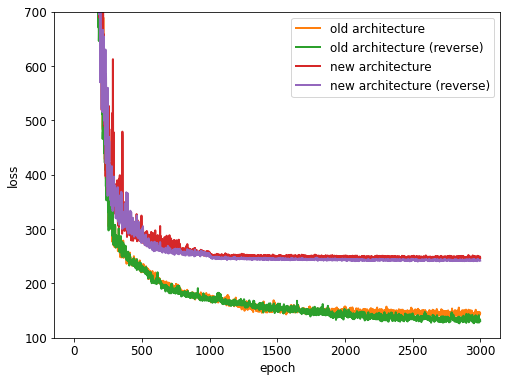

In [42]:
labels = ['old architecture', 'old architecture (reverse)', 'new architecture', 'new architecture (reverse)'] #labels = ['full-rank', 'mean-field']
x_list = [None]*4
colors = [cm.tab10(i+1) for i in [0, 1, 2, 3]]
linestyles = ['-']*4
plot_loss([losses_old[:3000], losses_old_rev, losses_uni_no, losses_uni_rev],
          labels, ymax=700, ymin=100, x_list=x_list, colors=colors, linestyles=linestyles) # 

In [ ]:
labels = ['lr=(0.001, 0.01), S=20', 'lr=(0.001, 0.01), S=30', 'lr=(0.001, 0.01), S=20'] #labels = ['full-rank', 'mean-field']
plot_loss([losses_no, losses_no_lo_la, losses_lo_long], labels, ymax=700, ymin=625) # 

In [ ]:
labels = ['old architecture (full)', 'new architecture (full)', 'new architecture (minibatch)'] #labels = ['full-rank', 'mean-field']
x_list = [None]*2 + [np.arange(0, 3001, 3), np.arange(0, 3001, 3)]*1
plot_loss([losses_old_high[:3000], losses_uni_high_decay, losses_mini_high_decay], labels, x_list=x_list, ymax=700, ymin=105) # 

In [ ]:
len(losses_mini_low)

In [ ]:
len(losses_mini_high)

In [ ]:
labels = ['no theta conditioning'] #labels = ['full-rank', 'mean-field']
plot_loss([losses_no], labels, ymax=1000, ymin=500) # 

In [ ]:
labels = ['convolution theta conditioning', 'linear theta conditioning', 'no theta conditioning'] #labels = ['full-rank', 'mean-field']
plot_loss([losses_conv[:100], losses_linear[:100], losses_no[:100]], labels, ymax=700, ymin=500) # 

In [ ]:
labels = ['convolution theta conditioning', 'linear theta conditioning', 'no theta conditioning',
          'convolution theta conditioning (minibatch)', 'linear theta conditioning (minibatch)', 'no theta conditioning (minibatch)'] #labels = ['full-rank', 'mean-field']
plot_loss([losses_conv[:100], losses_linear[:100], losses_no[:100],
           losses_mini_conv, losses_mini_linear, losses_mini_no],
          labels, ymax=600, ymin=510) # 

## Plot theta (final iteration)

In [43]:
# Extracts the distribution from a MeanField object
def extract_dist(q):
    a, b = q.lowers, q.uppers
    loc = q.means
    if not q.learn_cov:
        scale = torch.max(q.sds, torch.ones_like(q.sds) * 1e-8)
        #scale = D.transform_to(q.dist.arg_constraints['scale'])(q.sds)
        return q.dist(loc, scale=scale, a=a, b=b)
    else:
        scale = D.transform_to(q.dist.arg_constraints['scale_tril'])(q.sds)
        return q.dist(loc, scale_tril=scale, a=a, b=b)

In [44]:
#q_theta_old_high = extract_dist(q_theta_raw_old_high)
q_theta_old = extract_dist(q_theta_raw_old)
q_theta_old_rev = extract_dist(q_theta_raw_old_rev)

In [ ]:
q_theta_uni_high = extract_dist(q_theta_raw_uni_high)
q_theta_uni_high_decay = extract_dist(q_theta_raw_uni_high_decay)
q_theta_uni_low = extract_dist(q_theta_raw_uni_low)

In [ ]:
q_theta_mini_no = extract_dist(q_theta_raw_mini_no)
q_theta_mini_conv = extract_dist(q_theta_raw_mini_conv)
q_theta_mini_linear = extract_dist(q_theta_raw_mini_linear)

In [45]:
q_theta_uni_no = extract_dist(q_theta_raw_uni_no)
q_theta_uni_rev = extract_dist(q_theta_raw_uni_rev)
#q_theta_uni_conv = extract_dist(q_theta_raw_uni_conv)
#q_theta_uni_linear = extract_dist(q_theta_raw_uni_linear)

In [ ]:
q_init = extract_dist(q_init)

In [46]:
def plot_theta_post(p_theta, q_theta_list, theta_samples, labels, num_pts=1000, eps=1e-6, colors=None, linestyles=None):
    fig, axes = plt.subplots(1, 3, figsize=(4*3, 4))
    
    a, b = p_theta.a, p_theta.b
    theta_range = torch.from_numpy(np.linspace(a + eps, b - eps, num_pts)).float()
    
    pdf_prior = torch.exp(p_theta.log_prob(theta_range)).detach()
    approx_int_prior = pdf_prior.sum(0) * (b - a) / num_pts
    assert torch.allclose(approx_int_prior, torch.tensor(1.0), rtol=1e-3)
    
    # Load marginal posteriors
    pdf_post_list = []
    for q_theta in q_theta_list:
        if isinstance(q_theta, MultivariateLogitNormal):
            scale_post = torch.diag(q_theta.covariance_matrix).sqrt()
            q_marginal = RescaledLogitNormal(q_theta.loc, scale_post, a=a, b=b)
        else:
            q_marginal = q_theta
        pdf_post = torch.exp(q_marginal.log_prob(theta_range)).detach()
        pdf_post_list.append(pdf_post)
    
    param_names = ['$\\theta_0$', '$\\theta_1$']
    if colors is None:
        colors = [cm.tab10(i+1) for i in range(len(labels))]
    if linestyles is None:
        linestyles = ['-'] * len(labels)
    for i, ax in enumerate(axes):
        if i < 2:
            ax.plot(theta_range[:, i], pdf_prior[:, i], linewidth=2, label='prior')
            ax.axvline(theta[i], color='black', label='true $\\theta$')
            for pdf_post, post_dist, c, l in zip(pdf_post_list, labels, colors, linestyles):
                #label = 'posterior {}'.format(post_dist)
                ax.plot(theta_range[:, i], pdf_post[:, i], label=post_dist, color=c, linestyle=l)
                    
            ax.set_xlabel(param_names[i])
            if i == 0: ax.set_ylabel('density')
        else:
            handles, labels = axes[0].get_legend_handles_labels()
            ax.legend(handles, labels, loc='center left')
            ax.axis('off')
    plt.tight_layout()
    pass

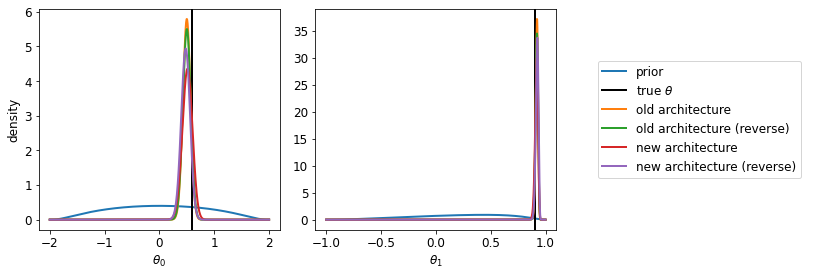

In [47]:
labels = ['old architecture', 'old architecture (reverse)', 'new architecture', 'new architecture (reverse)']
plot_theta_post(p_theta, [q_theta_old, q_theta_old_rev, q_theta_uni_no, q_theta_uni_rev],
                theta, labels, colors=colors, linestyles=linestyles)

In [ ]:
labels = ['old architecture (full)', 'new architecture (full)', 'new architecture (minibatch)']
plot_theta_post(p_theta, [q_theta_old_high, q_theta_uni_high_decay, q_theta_mini_high_decay], theta, labels)

In [ ]:
plot_theta_post(p_theta, [q_theta_conv, q_theta_linear, q_theta_no], theta, labels)

In [ ]:
labels_theta = labels + ['no theta conditioning (old)']
plot_theta_post(p_theta, [q_theta_conv, q_theta_linear, q_theta_no, q_theta_mini_conv, q_theta_mini_linear, q_theta_mini_no, q_theta_old],
                theta, labels_theta)

## Plot theta (history)

In [48]:
def extract_dist_hist(q, mean_list, sd_list):
    a, b = q.lowers, q.uppers
    loc = torch.stack(mean_list)
    if not q.learn_cov:
        scale =  torch.max(torch.stack(sd_list), torch.ones([]) * 1e-8)
        return q.dist(loc, scale=scale, a=a, b=b)
    else:
        scale = D.transform_to(q.dist.arg_constraints['scale_tril'])(torch.stack(sd_list))
        return q.dist(loc, scale_tril=scale, a=a, b=b)

In [49]:
q_hist_old = extract_dist_hist(q_theta_raw_old, means_old, sds_old)
q_hist_old_rev = extract_dist_hist(q_theta_raw_old_rev, means_old_rev, sds_old_rev)

In [50]:
q_hist_uni_no = extract_dist_hist(q_theta_raw_uni_no, means_uni_no, sds_uni_no)
q_hist_uni_rev = extract_dist_hist(q_theta_raw_uni_rev, means_uni_rev, sds_uni_rev)

In [53]:
def plot_theta_post_hist(p_theta, q_theta_list, theta_samples, labels, num_pts=1000, eps=1e-6, summarize=True):
    fig, axes = plt.subplots(1, 3, figsize=(4*3, 4))
    
    a, b = p_theta.a, p_theta.b
    theta_range = torch.from_numpy(np.linspace(a + eps, b - eps, num_pts)).float() # (num_pts, 2)
    
    pdf_prior = torch.exp(p_theta.log_prob(theta_range)).detach()
    approx_int_prior = pdf_prior.sum(0) * (b - a) / num_pts
    assert torch.allclose(approx_int_prior, torch.tensor(1.0), rtol=1e-3)
    
    # Load marginal posteriors
    pdf_post_list = []
    for q_theta in q_theta_list:
        if isinstance(q_theta, MultivariateLogitNormal):
            scale_post = torch.diagonal(q_theta.covariance_matrix, dim1=-2, dim2=-1).sqrt() 
            q_marginal = RescaledLogitNormal(q_theta.loc, scale_post, a=a, b=b)
        else:
            q_marginal = q_theta # parameters must have shape (num_samples, 2)
        pdf_post = torch.exp(q_marginal.log_prob(theta_range.unsqueeze(1))).detach() # (num_points, num_samples, 2)
        pdf_post_list.append(pdf_post)
        
    # Plot
    param_names = ['$\\theta_0$', '$\\theta_1$']
    colors = [cm.tab10(i+1) for i in range(len(q_theta_list))]
    for i, ax in enumerate(axes):
        if i < len(param_names):
            # Prior
            ax.plot(theta_range[:, i], pdf_prior[:, i], linewidth=2, label='prior')
            
            # True theta
            ax.axvline(theta[i], color='gray', label='true $\\theta$')
            
            # Posterior for each method
            for pdf_post, post_dist, c in zip(pdf_post_list, labels, colors):
                label = post_dist #'posterior {}'.format(post_dist)
                if summarize:
                    ax.plot(theta_range[:, i], pdf_post[:, :, i].mean(-1), label=label, color=c)
                else:
                    for j in range(pdf_post.shape[1]):
                        label = label if j == 0 else None
                        ax.plot(theta_range[:, i], pdf_post[:, j, i], label=label, color=c)
                    
            ax.set_xlabel(param_names[i])
            if i == 0: ax.set_ylabel('density')
        else:
            # Last cell is for legend
            handles, labels = axes[0].get_legend_handles_labels()
            ax.legend(handles, labels, loc='center left')
            ax.axis('off')
    plt.tight_layout()

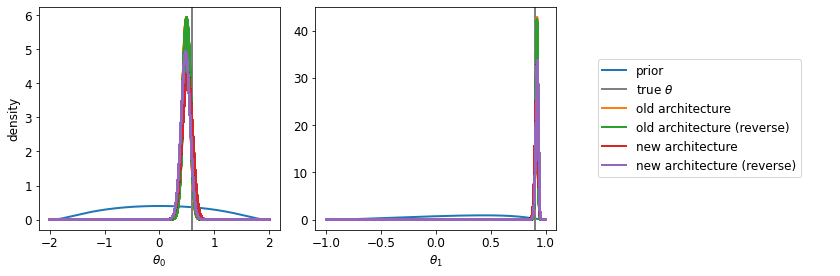

In [54]:
#labels = ['old architecture (full)', 'new architecture (full)', 'new architecture (minibatch)']
plot_theta_post_hist(p_theta, [q_hist_old, q_hist_old_rev, q_hist_uni_no, q_hist_uni_rev],
                     theta, labels, summarize=False)

In [ ]:
labels = ['no theta conditioning', 'convolution', 'linear']
plot_theta_post_hist(p_theta_high_decay, [q_hist_uni_high_decay, q_hist_uni_],
                     theta, labels, summarize=True)

In [ ]:
plot_theta_post_hist(p_theta_high_decay, [q_hist_old_high, q_hist_uni_high_decay, q_hist_mini_high_decay],
                     theta, labels, summarize=False)

## Plot states

In [26]:
def plot_path_post(net_list, T, dt, y, t_y, theta=None, q_theta_raw_list=None, labels=None, lidx=0, ridx=None,
                   title=None, state_dim=1, batch_size=30, summarize=False, alg_list=None, colors=None, linestyles=None):
    # algs: 0 - old net, 1 - new net, 2 - Kalman filter, 3 - Kalman smoother
    if alg_list is None:
        alg_list = [1] * len(net_list)
    if colors is None:
        colors = [cm.tab10(i+1) for i in range(len(labels))]
    if linestyles is None:
        linestyles = ['-'] * len(labels)
    
    #N, time_steps = x.shape
    times = torch.tensor(np.arange(0, T + dt, dt))
    if ridx is None: ridx = len(time)
    fig, axes = plt.subplots(state_dim, figsize=(15, 4*state_dim), sharex=True)
    axes = np.atleast_1d(axes)
    
    # Draw theta
    if theta is None:
        assert q_theta_raw_list is not None
        theta_list = []
        for i, q_theta_raw in enumerate(q_theta_raw_list):
            if q_theta_raw is not None:
                _, theta, _, _ = q_theta_raw(batch_size)
            else:
                assert alg_list[i] != 1 or net_list[i].theta_cond is False
                theta = None
            theta_list.append(theta)
    else:
        if q_theta_raw_list is not None:
            print('Using provided theta, ignoring q_theta')
    
    
    M = int(T / dt) + 1
    x_list = []
    for net, theta, alg in zip(net_list, theta_list, alg_list):
        if alg == 1 and net.theta_cond is False:
            assert theta is None
        if alg == 0:
            net.eval()
            x = net(batch_size)[0].detach() # (batch_size, n, state_dim)
        elif alg == 1:
            net.eval()
            x = net(batch_size, 0, M, theta=theta)[0].detach() # (batch_size, n, state_dim)
        else:
            x = net # kf object
        x_list.append(x)
    
    for i, ax in enumerate(axes):            
        #ax.plot(t_x, x[i, :], label='latent state')
        for x, label, color, l, alg in zip(x_list, labels, colors, linestyles, alg_list):
            if summarize:
                if alg < 2: # alg == 0 (old net) or 1 (new net)
                    net_left, net_center, net_right = torch.quantile(x[:, :, i], torch.tensor([0.025, 0.5, 0.975]), dim=0)
                else:
                    if alg == 2: # (Kalman filter)
                        net_center = x.mu_filter[:, i]
                        sd = x.sigma_filter[:, i, i].sqrt()
                    else: # alg == 3 (Kalman smoother)
                        net_center = x.mu_smooth[:, i]
                        sd = x.sigma_smooth[:, i, i].sqrt()
                    net_left, net_right = net_center - 2*sd, net_center + 2*sd
                
                #label_str = 'state {}'.format(label)
                ax.plot(times[lidx:ridx], net_center[lidx:ridx], label = label, color=color, linestyle=l)
                ax.fill_between(times[lidx:ridx], net_left[lidx:ridx], net_right[lidx:ridx],
                                alpha = 0.4, color=color) #, label = 'state 2.5-97.5%'
            else:
                for j in range(batch_size):
                    label_str = 'state {}'.format(label) if j == 0 else None
                    ax.plot(times, x[j, :, i], label=label_str, color=color)
                    
        obs_every = t_y[1] - t_y[0]
        y_lidx, y_ridx = int(lidx / obs_every), int(ridx / obs_every)
        ax.plot(t_y[y_lidx:y_ridx], y[i, y_lidx:y_ridx], label='observation', linestyle='', marker='o', color=cm.tab10(0))
        ax.legend()
        if i == 0 and title:
            ax.set_title(title)
    ax.set_xlabel('hour')
    plt.tight_layout()

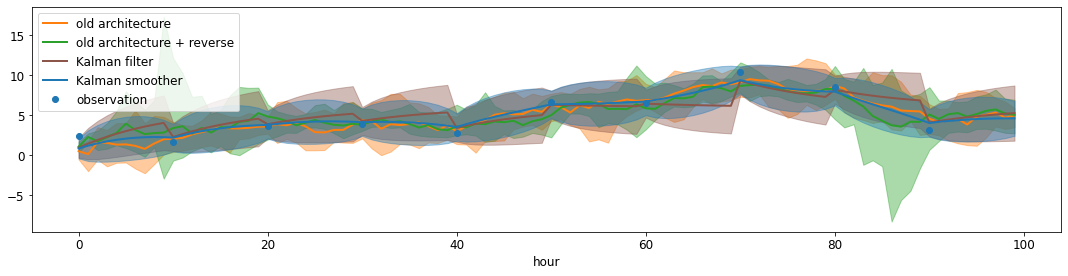

In [58]:
labels = ['old architecture', 'old architecture + reverse', 'Kalman filter', 'Kalman smoother']
plot_path_post([net_old, net_old_rev, kf, kf], T, dt_flow, y, t_y,
               q_theta_raw_list=[None] * 4,
               colors = [cm.tab10(i+1) for i in [0, 1,  4, -1]],
               batch_size=batch_size, labels=labels, summarize=True, alg_list=[0, 0, 2, 3], lidx=0, ridx=100)

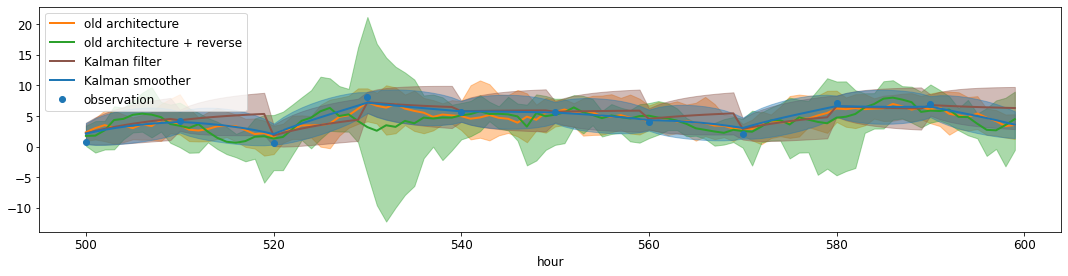

In [59]:
labels = ['old architecture', 'old architecture + reverse', 'Kalman filter', 'Kalman smoother']
plot_path_post([net_old, net_old_rev, kf, kf], T, dt_flow, y, t_y,
               q_theta_raw_list=[None] * 4,
               colors = [cm.tab10(i+1) for i in [0, 1,  4, -1]],
               batch_size=batch_size, labels=labels, summarize=True, alg_list=[0, 0, 2, 3], lidx=500, ridx=600)

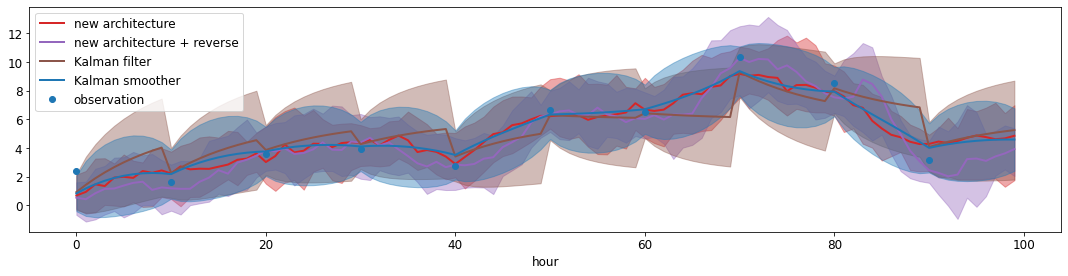

In [57]:
labels = ['new architecture', 'new architecture + reverse', 'Kalman filter', 'Kalman smoother']
plot_path_post([net_uni_no, net_uni_rev, kf, kf], T, dt_flow, y, t_y,
               q_theta_raw_list=[None] * 4,
               colors = [cm.tab10(i+1) for i in [2, 3, 4, -1]],
               batch_size=batch_size, labels=labels, summarize=True, alg_list=[1, 1, 2, 3], lidx=0, ridx=100)

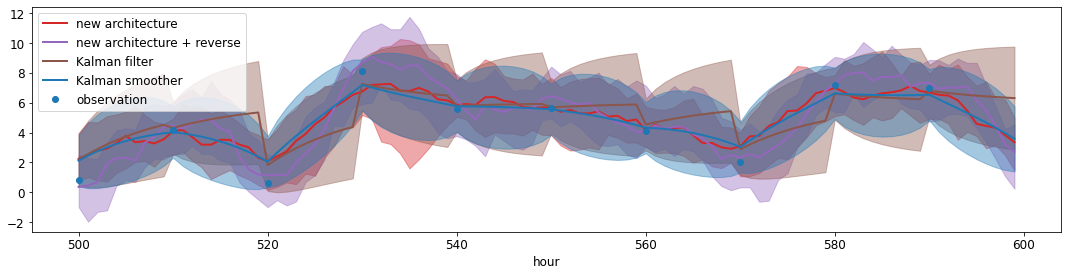

In [62]:
labels = ['new architecture', 'new architecture + reverse', 'Kalman filter', 'Kalman smoother']
plot_path_post([net_uni_no, net_uni_rev, kf, kf], T, dt_flow, y, t_y,
               q_theta_raw_list=[None] * 4,
               colors = [cm.tab10(i+1) for i in [2, 3, 4, -1]],
               batch_size=batch_size, labels=labels, summarize=True, alg_list=[1, 1, 2, 3], lidx=500, ridx=600)

In [ ]:
labels = ['no conditioning', 'convolution', 'linear', 'Kalman smoother']
plot_path_post([net_uni_no, net_uni_conv, net_uni_linear, kf], T, dt_flow, y, t_y,
               q_theta_raw_list=[None, q_theta_raw_uni_conv, q_theta_raw_uni_linear, None],
               colors = [cm.tab10(i) for i in [2, 3, 4, 0]],
               batch_size=batch_size, labels=labels, summarize=True, alg_list=[1, 1, 1, 2], lidx=0, ridx=100)

In [ ]:
labels = ['no conditioning (minibatch)', 'convolution (minibatch)', 'linear (minibatch)', 'Kalman smoother']
plot_path_post([net_mini_no, net_mini_conv, net_mini_linear, kf], T, dt_flow, y, t_y,
               q_theta_raw_list=[None, q_theta_raw_uni_conv, q_theta_raw_uni_linear, None],
               colors = [cm.tab10(i) for i in [2, 3, 4, 0]],
               batch_size=batch_size, labels=labels, summarize=True, alg_list=[1, 1, 1, 2],
               linestyles=['--', '--', '--', '-'])

In [ ]:
labels = ['Kalman smoother (posterior mode theta)', 'old architecture (full)', 'new architecture (full)', 'new architecture (minibatch)']
plot_path_post([kf_mode, net_old_low, net_uni_low, net_mini_low], T, dt_flow, y, t_y,
               q_theta_raw_list=[None]*4, colors = [cm.tab10(i+1) for i in [4, 0, 1, 2]],
               batch_size=batch_size, labels=labels, summarize=True, alg_list=[2, 0, 1, 1])

In [ ]:
plot_path_post([net_old_low, net_uni_low, net_mini_low], T, dt_flow, y, t_y, q_theta_raw_list=[None, None, None],
               batch_size=batch_size, labels=labels, summarize=True, is_new_arch_list=[False, True, True])

In [ ]:
plot_path_post([net_high, net_low], T, dt_flow, y, t_y, q_theta_raw_list=[None, None],
               batch_size=batch_size, labels=labels)

In [ ]:
plot_path_post([net_conv, net_linear, net_no, net_mini_conv, net_mini_linear, net_mini_no],
               T, dt_flow, y, t_y,
               q_theta_raw_list=[q_theta_raw_conv, q_theta_raw_linear, None, q_theta_raw_mini_conv, q_theta_raw_mini_linear, None],
               batch_size=batch_size, labels=labels)

In [ ]:
plot_path_post([net_conv, net_linear, net_no, net_mini_conv, net_mini_linear, net_mini_no],
               T, dt_flow, y, t_y,
               q_theta_raw_list=[q_theta_raw_conv, q_theta_raw_linear, None, q_theta_raw_mini_conv, q_theta_raw_mini_linear, None],
               batch_size=batch_size, labels=labels, summarize=True)

## Plot correlations

In [184]:
def plot_corr(q_theta_list, labels, param_names, num_samples=100000):
    plt.rcParams.update({'font.size': 12})
    
    # Calculate empirical correlation
    corr_list = []
    for q_theta in q_theta_list:
        assert isinstance(q_theta, MultivariateLogitNormal)
        samples = q_theta.sample((num_samples, )) # (N, D)
        #print(samples[:10])
        corr_mc = np.corrcoef(samples.T)
        corr_list.append(corr_mc)
    
    # Plot
    num_cols = len(q_theta_list)
    fig, axes = plt.subplots(1, num_cols, figsize=(4*num_cols, 4), sharey=True)
    axes = np.atleast_1d(axes)
    D = len(q_theta_list[0].loc)
    
    for i, ax in enumerate(axes):
        corr_mat = corr_list[i]
        plot = ax.imshow(corr_mat, cmap='coolwarm', vmin=-1, vmax=1)
        #ax.text(0.5, 0.5, corr_list[i], ha='center', va='center')
        ax.set_xticks(range(D))
        ax.set_xticklabels(param_names)
        ax.set_yticks(range(D))
        ax.set_yticklabels(param_names)
        ax.set_title(labels[i])
        
        for (j,i), val in np.ndenumerate(corr_mat):
            label = val.round(4)
            ax.text(i,j,label,ha='center',va='center')
        
    plt.tight_layout()
    plt.colorbar(plot, ax=axes, shrink=0.8)
    plt.suptitle('Correlation between parameters')
    plt.show()

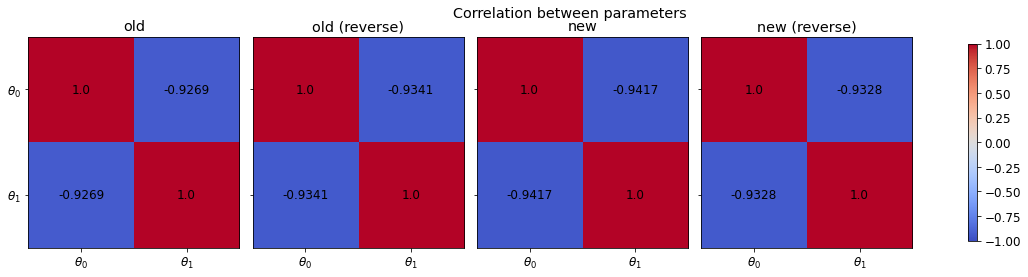

In [185]:
plot_corr([q_theta_old, q_theta_old_rev, q_theta_uni_no, q_theta_uni_rev],
          ['old', 'old (reverse)', 'new', 'new (reverse)'], ['$\\theta_0$', '$\\theta_1$'])

In [220]:
def plot_theta_contour(q_theta_list, labels, num_pts=1000, eps=1e-6, a=None, b=None, ncols=2):
    if a is None:
        a = torch.zeros(len(labels))
    else:
        a = torch.as_tensor(a)
    if b is None:
        b = torch.ones(len(labels))
    else:
        b = torch.as_tensor(b)
        
    nrows = len(labels) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.5*ncols, 4*nrows), sharex=True, sharey=True)
    axes = np.atleast_1d(axes)
    
    theta_range = torch.from_numpy(np.linspace(a + eps, b - eps, num_pts)).float()
    theta0, theta1 = torch.meshgrid(theta_range[:, 0], theta_range[:, 1])
    vals = torch.stack((theta0, theta1), dim=-1)
    
    k = 0
    for i, row in enumerate(axes):
        for j, ax in enumerate(row):
            if k < len(labels):
                # Compute joint pdf
                pdfs = torch.exp(q_theta_list[k].log_prob(vals)).detach()
                
                # Plot
                plot = ax.contourf(theta0, theta1, pdfs, cmap='Blues')
                ax.set_xlabel('$\\theta_0$')
                ax.set_ylabel('$\\theta_1$')
                ax.set_title(labels[k])
            else:
                fig.delaxes(axes[i, j])
                
            k += 1
            
    plt.tight_layout()
    plt.colorbar(plot, ax=axes)
    plt.show()

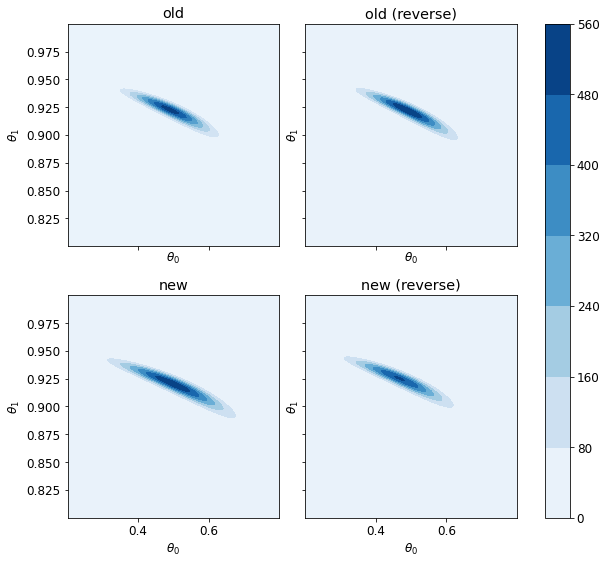

In [221]:
labels = ['old', 'old (reverse)', 'new', 'new (reverse)']
plot_theta_contour([q_theta_old, q_theta_old_rev, q_theta_uni_no, q_theta_uni_rev],
                   labels, a=[0.2, 0.8], b=[0.8, 1.0], ncols=2)

In [68]:
q_theta_uni_no.covariance_matrix

tensor([[ 0.00959913, -0.01607697],
        [-0.01607697,  0.02989969]], grad_fn=<ExpandBackward>)

In [ ]:
plot_corr([q_theta_mini_no, q_theta_mini_conv, q_theta_mini_linear], ['no conditioning (minibatch)', 'convolution (minibatch)', 'linear (minibatch)'],
          ['$\\theta_0$', '$\\theta_1$'])

In [198]:
eps, num_pts = 1e-6, 1000
a, b = torch.tensor([0.2, 0.8]), torch.tensor([0.8, 1.])
theta_range = torch.from_numpy(np.linspace(a + eps, b - eps, num_pts)).float()
i, j = torch.meshgrid(theta_range[:, 0], theta_range[:, 1]) # (theta0 on y axis == rows)
i.shape, j.shape # (theta0, theta1)

(torch.Size([1000, 1000]), torch.Size([1000, 1000]))

In [167]:
x, y = np.meshgrid(theta_range0, theta_range1) # (theta0 on x axis == cols) theta0: 0-1, theta1: 0.5-1
x.shape, y.shape # (theta0, theta1)

((1000, 1000), (1000, 1000))

In [168]:
vals_xy = torch.stack((torch.tensor(x), torch.tensor(y)), dim=-1)
pdfs_xy = torch.exp(q_theta_old.log_prob(vals_xy)).detach()
pdfs_xy.shape

torch.Size([1000, 1000])

In [169]:

pdfs_ij.shape

torch.Size([1000, 1000])

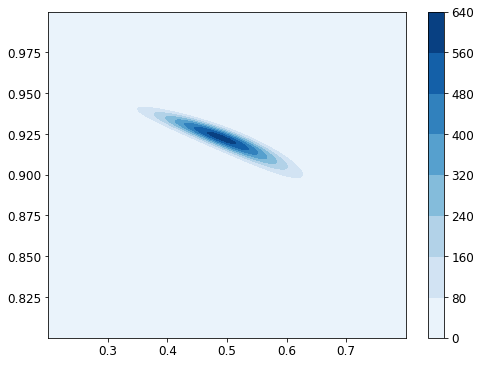

In [175]:
plot = plt.contourf(i, j, pdfs_ij, cmap='Blues')
plt.colorbar(plot)

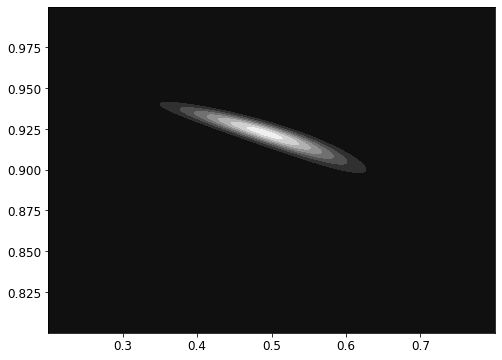

In [171]:
plt.contourf(x, y, pdfs_xy, cmap='gray')

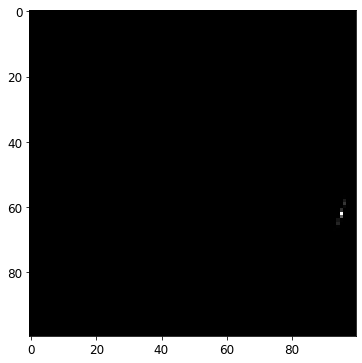

In [117]:
plt.imshow(pdfs, cmap='gray')

In [124]:
a, b

(tensor([-2., -1.]), tensor([2., 1.]))

In [88]:
samples = q_theta_old.sample((10000, ))

No handles with labels found to put in legend.


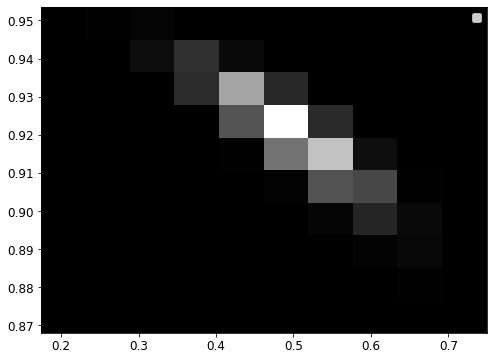

In [89]:
plt.hist2d(np.array(samples[:, 0]), np.array(samples[:, 1]), cmap='gray')
plt.legend()

In [ ]:
a, b = p_theta.a, p_theta.b
    theta_range = torch.from_numpy(np.linspace(a + eps, b - eps, num_pts)).float() # (num_pts, 2)
    
    pdf_prior = torch.exp(p_theta.log_prob(theta_range)).detach()
    approx_int_prior = pdf_prior.sum(0) * (b - a) / num_pts
    assert torch.allclose(approx_int_prior, torch.tensor(1.0), rtol=1e-3)
    
    # Load marginal posteriors
    pdf_post_list = []
    for q_theta in q_theta_list:
        if isinstance(q_theta, MultivariateLogitNormal):
            scale_post = torch.diagonal(q_theta.covariance_matrix, dim1=-2, dim2=-1).sqrt() 
            q_marginal = RescaledLogitNormal(q_theta.loc, scale_post, a=a, b=b)
        else:
            q_marginal = q_theta # parameters must have shape (num_samples, 2)
        pdf_post = torch.exp(q_marginal.log_prob(theta_range.unsqueeze(1))).detach() # (num_points, num_samples, 2)
        pdf_post_list.append(pdf_post)

## Save results

In [ ]:
loss_file = '{}/new_uni_loss.pt'.format(save_dir)
net_file = '{}/new_uni_net.pt'.format(save_dir)
q_raw_file = '{}/new_uni_q_raw.pt'.format(save_dir)
q_hist_file = '{}/new_uni_q_hist.pt'.format(save_dir)
torch.save([losses_uni_high_decay, losses_conv, losses_linear], loss_file) # , losses_trunc_mf
torch.save([net_uni_high_decay, net_conv, net_linear], net_file)
torch.save([q_theta_raw_high_decay, q_theta_raw_conv, q_theta_raw_linear], q_raw_file) # , q_theta_trunc_mf
torch.save([(means_high_decay, sds_high_decay), (means_conv, sds_conv), (means_linear, sds_linear)], q_hist_file) # , times_trunc_mf

## Load results

Comparing old v new arch

In [ ]:
loss_file = '{}/new_uni_no_loss.pt'.format(save_dir)
net_file = '{}/new_uni_no_net.pt'.format(save_dir)
q_raw_file = '{}/new_uni_no_q_raw.pt'.format(save_dir)
q_hist_file = '{}/new_uni_no_q_hist.pt'.format(save_dir)
losses_uni_low, losses_uni_high, losses_uni_high_decay = torch.load(loss_file)
net_uni_low, net_uni_high, net_uni_high_decay = torch.load(net_file)
q_theta_raw_uni_low, q_theta_raw_uni_high, q_theta_raw_uni_high_decay = torch.load(q_raw_file)
means_uni_high_decay, sds_uni_high_decay = torch.load(q_hist_file)

In [ ]:
loss_file = '{}/new_mini_no_loss.pt'.format(save_dir)
net_file = '{}/new_mini_no_net.pt'.format(save_dir)
q_raw_file = '{}/new_mini_no_q_raw.pt'.format(save_dir)
q_hist_file = '{}/new_mini_no_q_hist.pt'.format(save_dir)
losses_mini_low, losses_mini_high, losses_mini_high_decay = torch.load(loss_file)
net_mini_low, net_mini_high, net_mini_high_decay = torch.load(net_file)
q_theta_raw_mini_low, q_theta_raw_mini_high, q_theta_raw_mini_high_decay = torch.load(q_raw_file)
means_mini_high_decay, sds_mini_high_decay = torch.load(q_hist_file)

In [24]:
loss_file = '{}/old_loss.pt'.format(save_dir)
net_file = '{}/old_net.pt'.format(save_dir)
q_raw_file = '{}/old_q_raw.pt'.format(save_dir)
q_hist_file = '{}/old_q_hist.pt'.format(save_dir)
_, losses_old, _ = torch.load(loss_file)
_, net_old, _ = torch.load(net_file)
_, q_theta_raw_old, _ = torch.load(q_raw_file)
means_old, sds_old = torch.load(q_hist_file)

In [17]:
kf_file = '{}/kf.pt'.format(save_dir)
kf, kf_mode = torch.load(kf_file)

Comparing theta conditioning

In [16]:
loss_file = '{}/new_uni_loss.pt'.format(save_dir)
net_file = '{}/new_uni_net.pt'.format(save_dir)
q_raw_file = '{}/new_uni_q_raw.pt'.format(save_dir)
q_hist_file = '{}/new_uni_q_hist.pt'.format(save_dir)
losses_uni_no, losses_uni_conv, losses_uni_linear = torch.load(loss_file)
net_uni_no, net_uni_conv, net_uni_linear = torch.load(net_file)
q_theta_raw_uni_no, q_theta_raw_uni_conv, q_theta_raw_uni_linear = torch.load(q_raw_file)
(means_uni_no, sds_uni_no), (means_uni_conv, sds_uni_conv), (means_uni_linear, sds_uni_linear) = torch.load(q_hist_file)

In [ ]:
loss_file = '{}/new_mini_loss.pt'.format(save_dir)
net_file = '{}/new_mini_net.pt'.format(save_dir)
q_raw_file = '{}/new_mini_q_raw.pt'.format(save_dir)
q_hist_file = '{}/new_mini_q_hist.pt'.format(save_dir)
losses_mini_no, losses_mini_conv, losses_mini_linear = torch.load(loss_file)
net_mini_no, net_mini_conv, net_mini_linear = torch.load(net_file)
q_theta_raw_mini_no, q_theta_raw_mini_conv, q_theta_raw_mini_linear = torch.load(q_raw_file)
(means_mini_no, sds_mini_no), (means_mini_conv, sds_mini_conv), (means_mini_linear, sds_mini_linear) = torch.load(q_hist_file)

Reverse-order permutation

In [15]:
loss_file = '{}/new_uni_rev_loss.pt'.format(save_dir)
net_file = '{}/new_uni_rev_net.pt'.format(save_dir)
q_raw_file = '{}/new_uni_rev_q_raw.pt'.format(save_dir)
q_hist_file = '{}/new_uni_rev_q_hist.pt'.format(save_dir)
losses_uni_rev = torch.load(loss_file) # , losses_trunc_mf
net_uni_rev = torch.load(net_file)
q_theta_raw_uni_rev = torch.load(q_raw_file) # , q_theta_trunc_mf
means_uni_rev, sds_uni_rev = torch.load(q_hist_file) # , times_trunc_mf

In [23]:
loss_file = '{}/old_rev_loss.pt'.format(save_dir)
net_file = '{}/old_rev_net.pt'.format(save_dir)
q_raw_file = '{}/old_rev_q_raw.pt'.format(save_dir)
q_hist_file = '{}/old_rev_q_hist.pt'.format(save_dir)
losses_old_rev = torch.load(loss_file) # , losses_trunc_mf
net_old_rev = torch.load(net_file)
q_theta_raw_old_rev = torch.load(q_raw_file) # , q_theta_trunc_mf
means_old_rev, sds_old_rev = torch.load(q_hist_file) # , times_trunc_mf

## Archive
Consider a simplified transition distribution given by:
$$ \mathbf{x}_t = \mathbf{A}_t \mathbf{x}_{t-1} + \boldsymbol{\epsilon}_t$$

where $\boldsymbol{\epsilon}_t \sim N(\mathbf{0}, \mathbf{Q}_t)$ is a Gaussian system noise.

$x_t \sim \text{MultivariateNormal}(A_tx_{t-1}, Q_t)$

For simplicity, let A = diag(\theta), Q is known. Should we do 1 state dim?

In [ ]:
a = torch.empty(2, 3, 1)

In [ ]:
a.shape

In [ ]:
torch.as_tensor(a)